# Importing required packages

In [87]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import KNNImputer

# Read data

In [2]:
data = pd.read_csv('bankruptcy.csv')
data.head()
data.shape

(10503, 65)

In [3]:
data_description = data.describe() 
data_description

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,...,1.050300e+04,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,...,6.638549e+03,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,...,5.989196e+04,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,...,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,...,1.462100e+01,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+00,0.000000,0.050945,1.111000,1.199000,0.515500,...,8.822900e+02,0.051765,0.106880,0.953060,0.002976,9.952100e+00,6.677300,7.066400e+01,5.139200,4.059300
75%,0.123805,0.689330,0.419545,2.959500,5.608400e+01,0.072584,0.142275,2.857100,2.059100,0.725635,...,4.348900e+03,0.130010,0.271310,0.995927,0.240320,2.093600e+01,10.587500,1.182200e+02,8.882600,9.682750
max,52.652000,480.730000,17.708000,53433.000000,6.854400e+05,45.533000,52.652000,53432.000000,740.440000,11.837000,...,3.380500e+06,293.150000,552.640000,18118.000000,7617.300000,3.660200e+06,4470.400000,1.073500e+06,1974.500000,21499.000000


# Check null/NA Values

In [4]:
data.isnull().sum().nlargest(10)

Attr37    4736
Attr21     807
Attr27     715
Attr60     592
Attr45     591
Attr28     228
Attr53     228
Attr54     228
Attr64     228
Attr24     227
dtype: int64

# Impute Missing Values using KNNImputer

In [5]:
imputer = KNNImputer(n_neighbors=10, weights="uniform")
data_impute = data.drop('class', axis = 1)
imputed_data = imputer.fit_transform(data_impute)
imputed_data_df = pd.DataFrame(imputed_data, index=data_impute.index, columns=data_impute.columns)

In [6]:
data = pd.concat([imputed_data_df, data['class']], axis = 1)
data.isnull().sum()

Attr1     0
Attr2     0
Attr3     0
Attr4     0
Attr5     0
         ..
Attr61    0
Attr62    0
Attr63    0
Attr64    0
class     0
Length: 65, dtype: int64

# Split data in features and labels

In [7]:
label_column = 'class'
feature_columns = [c for c in data.columns if c != label_column]
X = data[feature_columns]
y = [int(v.replace("b","").replace("'","")) for v in data[label_column].values]

#### The data set is not balanced, observartions of class 1, i.e bankruptcy is significantly lesser than class 0.

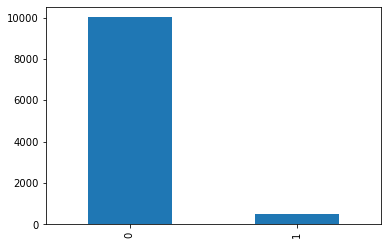

In [8]:
pd.Series(y).value_counts().plot(kind='bar')

# Oversampling the data using SMOTE

#### To balance out the dataset, oversample the minority class with varaitions to be equal to the majority class

In [9]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_over_sampled, y_over_sampled = oversample.fit_resample(X, y)

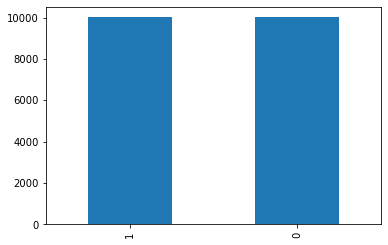

In [10]:
pd.Series(y_over_sampled).value_counts().plot(kind='bar')

## Create a hold out validation set to use after model selection 

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_holdout_test, y_train, y_holdout_test = train_test_split(X_over_sampled, y_over_sampled, 
                                                                    test_size=0.20, random_state=42)

In [12]:
X_train.shape

(16012, 64)

In [13]:
X_holdout_test.shape

(4004, 64)

# Model Selection Using AUC-ROC score

In [272]:
X_tv, X_test, y_tv, y_test = train_test_split(X_train, y_train)

models = [
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 200]
        }
    },
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(max_iter=10000),
        'params': {
            'C': np.logspace(-2, 0, 10)
        }
    },
    {
        'name': 'Gradient Boosting Classifier',
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate': np.logspace(-2, 0, 3)
        }
    }
]

kfold = KFold(n_splits=5, shuffle=True)

for m in models:
    pipeline = make_pipeline(
        StandardScaler(),
        GridSearchCV(
            estimator=m['model'],
            param_grid=m['params'],
            scoring='roc_auc',
            n_jobs=-1,
            cv=kfold
        )
    )
    
    pipeline.fit(X_tv, y_tv)
    predictions = pipeline.predict(X_test)
    m['score'] = roc_auc_score(y_test, predictions, average='micro')
    m['pipeline'] = pipeline

In [273]:
for m in models:
    print(f"Model: {m['name']}: score = {m['score']:.4f}")

Model: Random Forest: score = 0.9731
Model: Logistic Regression: score = 0.7044
Model: Gradient Boosting Classifier: score = 0.9607


# The best model selected is Random Forest 

In [14]:
selected_model = RandomForestClassifier(n_estimators=200)
pipeline = make_pipeline(StandardScaler(), selected_model)

## How does the selected model perform on holdout data

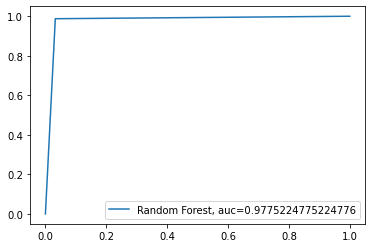

In [16]:
pipeline.fit(X_train, y_train)
predicitions = pipeline.predict(X_holdout_test)

fpr, tpr, _ = roc_curve(y_holdout_test, predicitions)
auc = roc_auc_score(y_holdout_test, predicitions)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Feature Importance

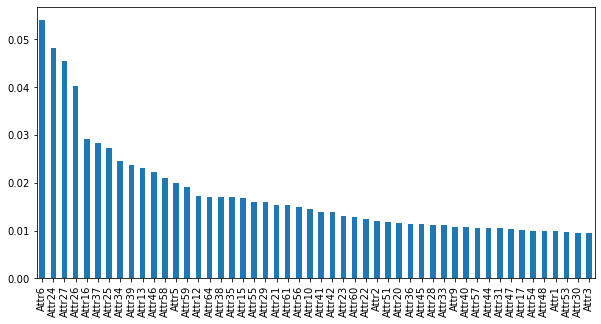

In [17]:
plt.subplots(figsize = (10,5))
feature_importances = pd.Series(selected_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False,inplace=True)
feature_importances.nlargest(50).plot(kind='bar')

### Parsing the meaning of features from text file

In [18]:
features_dict = {}
with open("features.txt") as f:
    for line in f:
        feature_key = line.split(" ", 1)[0].replace("X", "Attr")
        feature_name = line.split(" ", 1)[1]
        features_dict[feature_key] = feature_name

## Getting the meanings of top n features 

In [19]:
n_top_features = 15

top_n_feature_names = [features_dict[f].strip() for f in feature_importances.nlargest(n_top_features).index]
top_n_features = dict(zip(top_n_feature_names, feature_importances.nlargest(n_top_features)))

counter = 1
for i in top_n_features.keys():
    print(f"{counter}. {i}: {top_n_features[i]:.4f}")
    counter += 1

1. retained earnings / total assets: 0.0541
2. gross profit (in 3 years) / total assets: 0.0482
3. profit on operating activities / financial expenses: 0.0455
4. (net profit + depreciation) / total liabilities: 0.0402
5. (gross profit + depreciation) / total liabilities: 0.0292
6. (current assets - inventories) / long-term liabilities: 0.0284
7. (equity - share capital) / total assets: 0.0272
8. operating expenses / total liabilities: 0.0245
9. profit on sales / sales: 0.0238
10. (gross profit + depreciation) / sales: 0.0231
11. (current assets - inventory) / short-term liabilities: 0.0223
12. total costs /total sales: 0.0209
13. [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365: 0.0200
14. long-term liabilities / equity: 0.0191
15. gross profit / short-term liabilities: 0.0173


# Correlation in top features

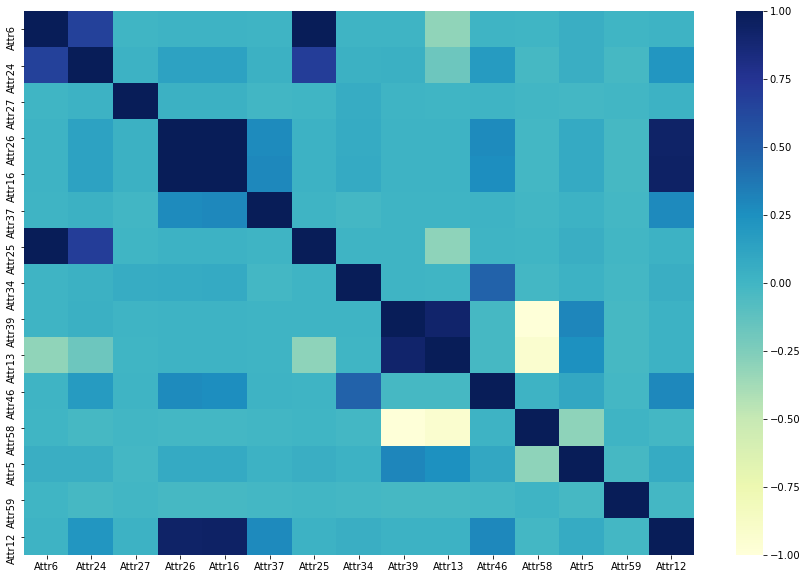

In [119]:
corr = X_over_sampled[feature_importances.nlargest(15).index].sample(1000).corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, vmax = 1, vmin = -1,
            yticklabels=corr.columns, cmap = "YlGnBu")

## Remove correlated columns

In [74]:
upper_tri = corr.abs().where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
correlated_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
important_columns = list(set(feature_importances.nlargest(n_top_features).index) - set(correlated_cols))

# Principal Component Analysis

In [75]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_over_sampled[important_columns])

print(f"Three principal components can explain {pca.explained_variance_ratio_.sum() * 100:.3f}% of the variance")


Three principal components can explain 99.998% of the variance


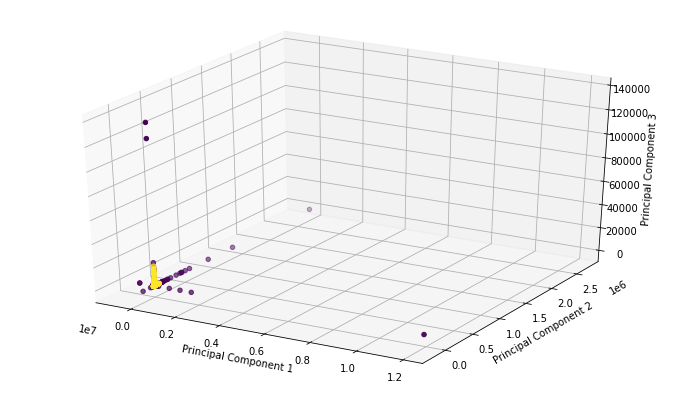

In [76]:
ax = plt.figure(figsize=(12,7)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y_over_sampled
)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

## train a model on the top n features

In [77]:
pipeline.fit(X_train[important_columns], y_train)
top_n_model_predicitions = pipeline.predict(X_holdout_test[important_columns])
print(f"Using top {len(important_columns)} features")

Using top 12 features


## Model performance on top n features

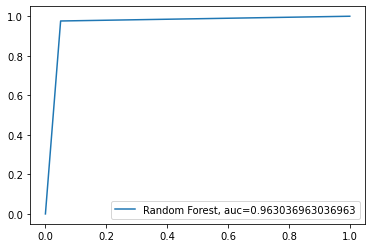

In [78]:
fpr, tpr, _ = roc_curve(y_holdout_test, top_n_model_predicitions)
auc = roc_auc_score(y_holdout_test, top_n_model_predicitions)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.legend(loc=4)
plt.show()